In [1]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [2]:
from giant_learning.gradient_descent import ProjectedGradientDescent
from giant_learning.erf_erf import ProjectedErfErfOverlaps

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth

target = ProjectedErfErfOverlaps._target
activation = ProjectedErfErfOverlaps._activation
activation_derivative = ProjectedErfErfOverlaps._activation_derivative

p = 1
k = 1
ds = np.array([50, 100, 500, 1000], dtype=np.int64)
n = (ds.astype(np.float64)**1).astype(np.int64)
gamma0 = 8.
gamma_scaling = ds**(-1/2)
gamma = gamma0*gamma_scaling
noise = 1.1e-5
t = 0
T = 1000

test_errors_simulation = np.zeros((len(ds), T+1))
test_errors_theory = np.zeros((len(ds), T+1))

for i,d in enumerate(ds):
    # Initial conditions
    Wtarget = orth((normalize(np.random.normal(size=(k,d)), axis=1, norm='l2')).T).T
    Wtild = normalize(np.random.normal(size=(p,d)), axis=1, norm='l2')
    Wtild_target = np.einsum('ji,ri,rh->jh', Wtild , Wtarget ,Wtarget)
    W0_orth =  normalize(Wtild - Wtild_target, axis=1, norm='l2')
    W0 = (t*normalize(Wtild_target,norm='l2',axis=1) + np.sqrt(1-t**2)*W0_orth)
    a0 = np.ones(p) 

    P = Wtarget @ Wtarget.T
    M0 = W0 @ Wtarget.T
    Q0 = W0 @ W0.T

    # Simulation
    gd = ProjectedGradientDescent(
        target, Wtarget, n[i],
        activation, W0, a0, activation_derivative, 
        gamma[i], noise, second_layer_update = False, test_size = None, analytical_error= 'erferf',
        seed=i
    )
    # Theory
    th = ProjectedErfErfOverlaps(
        P, M0, Q0, a0,
        gamma[i], noise,
        I4_diagonal=float(d/n[i]), I4_offdiagonal=True, I3=True,
        second_layer_update=False
    )

    gd.train(T, verbose=True)
    test_errors_simulation[i] = gd.test_errors
    th.train(T, verbose=True)
    test_errors_theory[i] = th.test_errors

    print('d =', d, 'done')

# Theory asymptotic

asth = ProjectedErfErfOverlaps(
    P, M0, Q0, a0,
    gamma[-1], noise,
    I4_diagonal=True, I4_offdiagonal=False, I3=True,
    second_layer_update=False
)

asth.train(T, verbose=True)

100%|██████████| 1000/1000 [00:00<00:00, 19029.47it/s]


d = 50 done


100%|██████████| 1000/1000 [00:00<00:00, 22203.36it/s]


d = 100 done


100%|██████████| 1000/1000 [00:00<00:00, 20429.03it/s]


d = 500 done


100%|██████████| 1000/1000 [00:00<00:00, 23749.63it/s]


d = 1000 done


100%|██████████| 1000/1000 [00:00<00:00, 29993.16it/s]


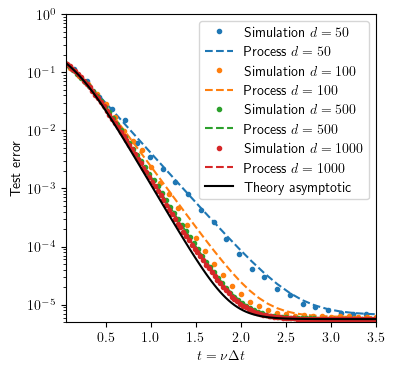

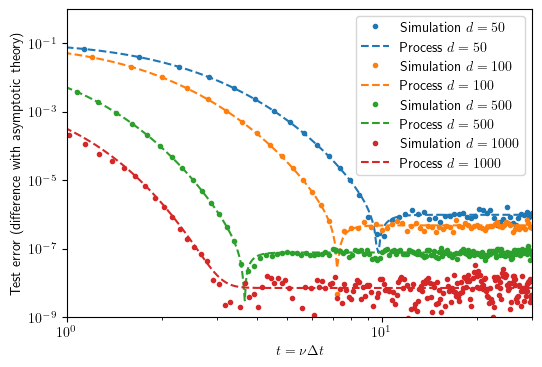

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for i,d in enumerate(ds):
    sim_plot = ax.plot(np.arange(T+1)*gamma_scaling[i], abs(test_errors_simulation[i]), label='Simulation $d={}$'.format(d), marker='.', markevery=1, ls='')
    ax.plot(np.arange(T+1)*gamma_scaling[i], abs(test_errors_theory[i]), label='Process $d={}$'.format(d), linestyle='--', marker='',color=sim_plot[0].get_color())

ax.plot(np.arange(T+1)*gamma_scaling[-1], asth.test_errors, label='Theory asymptotic', linestyle='-', marker='',color='black')

ax.set_xlabel(r'$t = \nu \Delta t$') 
ax.set_ylabel('Test error')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(5e-2,3.5)
ax.set_ylim(5e-6,1e0)
ax.legend()
plt.show()

fig.savefig('figures/finitesize_asymptotic[test_error].pdf', bbox_inches='tight')


# Difference plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i,d in enumerate(ds):
    sim_plot = ax.plot(np.arange(T+1)*gamma_scaling[i], abs(test_errors_simulation[i]-asth.test_errors), label='Simulation $d={}$'.format(d), marker='.', markevery=4, ls='')
    ax.plot(np.arange(T+1)*gamma_scaling[i], abs(test_errors_theory[i]-asth.test_errors), label='Process $d={}$'.format(d), linestyle='--', marker='',color=sim_plot[0].get_color())

ax.set_xlabel(r'$t=\nu \Delta t$') 
ax.set_ylabel('Test error (difference with asymptotic theory)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,30)
ax.set_ylim(1e-9,1e0)
ax.legend()

fig.savefig('figures/finitesize_asymptotic[differnce].pdf', bbox_inches='tight')